In [1]:
using Plots
using QuadGK
using LinearAlgebra

In [2]:
aomega(omega) = exp(-0.5 * (omega+3)^2)/sqrt(2*π) + exp(-0.1 * (omega-5)^2)/sqrt(2*π)

aomega (generic function with 1 method)

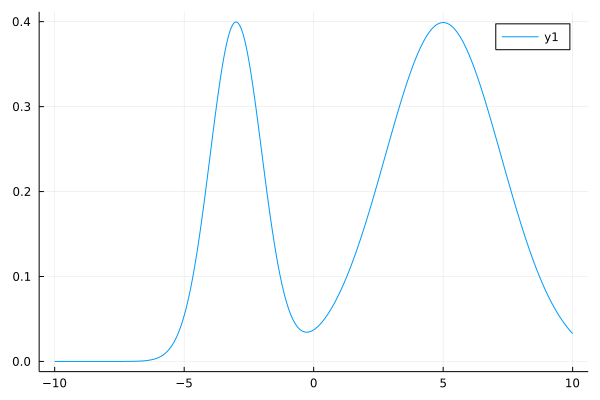

In [3]:
wmax = 10
omegas = LinRange(-wmax, wmax, 1000)
plot(omegas, aomega.(omegas))

In [4]:
nmom = 10
Tp = Float64[]
for mom in 0:(nmom-1)
    push!(Tp, quadgk(x -> (x^mom) * aomega(x), 0, wmax)[1])
end
Tp

10-element Vector{Float64}:
      2.1807395479212532
     10.89733040376515
     63.744534104880756
    411.31770157799195
   2849.016963526231
  20834.076371887862
 159022.21334378343
      1.2563974692549175e6
      1.0210405977292152e7
      8.493434037226106e7

In [5]:
nmom = 10
Th = Float64[]
for mom in 0:(nmom-1)
    push!(Th, quadgk(x -> (x^mom) * aomega(x), -wmax, 0)[1])
end
Th

10-element Vector{Float64}:
       1.0269892657501456
      -3.0224222177401447
      10.031292063148035
     -36.06307711087044
     138.15766828526185
    -558.4695468232063
    2365.5982724542773
  -10446.088756153695
   47893.50134136365
 -227239.99266864342

$$
T^{(n)}_p = (-1)^{n+1} \frac{d^n G(\tau)}{d\tau^n} \mid_{\tau=0^+}
$$

$$
T^{(n)}_h = (-1)^{n} \frac{d^n G(\tau)}{d\tau^n} \mid_{\tau=0^+}
$$

$$
S_n = T[0]^{-1/2} T[n] T[0]^{-1/2}
$$

In [6]:
function reconst(T)
    nmom = length(T)
    S = (1/sqrt(T[1])) * T * (1/sqrt(T[1]))
    println(S)

    As = Dict{Int,ComplexF64}()
    Bs = Dict{Int,ComplexF64}()
    Cs = Dict{Tuple{Int,Int},ComplexF64}()

    # Initial values
    As[0] = S[2]
    Bs[0] = 0.0
    Cs[0,0] = 1.0

    function get_S(i)
        i <= nmom-1 ? S[i+1] : 0.0
    end
    
    function get_Cs(n, j)::ComplexF64
        if j < 0 || j > n || n < 0
            return 0.0
        end
        return Cs[(n, j)]
    end

    for n in 0:nmom
        #println("n = $n")
        # Update B[n+1]
        bfirst = sum(conj(Cs[n,l]) * get_S(j+l+1) * get_Cs(n, j-1) for j in 0:(n+1), l in 0:n)
        Bs[n+1] = sqrt(bfirst  - As[n]^2  - conj(Bs[n]^2))

        # C(n+1, j) for j = 0, ..., n+1 (otherwise 0)
        for j in 0:(n+1)
            Cs[(n+1, j)] = (get_Cs(n, j-1) - get_Cs(n, j) * As[n] - get_Cs(n-1, j) * conj(Bs[n])) / Bs[n+1]
        end

        # Update A[n+1]
        As[n+1] = sum(conj(get_Cs(n+1, l) * get_S(j+l+1) * get_Cs(n+1, j)) for j in 0:(n+1), l in 0:(n+1))

        if length(As) >= (nmom + 1) ÷ 2
            break
        end
    end
    return  As, Bs
end

As, Bs = reconst(Tp)
Ash, Bsh = reconst(Th)

[0.9999999999999999, 4.997080194263828, 29.230695690204715, 188.61385898654075, 1306.4453140412845, 9553.674757605753, 72921.23146726449, 576133.6655046924, 4.682084106295507e6, 3.8947493960580036e7]
[1.0, -2.9429929976263884, 9.767669826442498, -35.11533987118046, 134.52688639773373, -543.7929737418262, 2303.4303778495373, -10171.565667264826, 46634.86069290189, -221268.12835055302]


(Dict{Int64, ComplexF64}(0 => -2.9429929976263884 + 0.0im, 4 => -3.6316048335065716 + 0.0im, 2 => -2.914370228375958 + 0.0im, 3 => -3.2916509098347433 + 0.0im, 1 => -2.8133327731362066 + 0.0im), Dict{Int64, ComplexF64}(0 => 0.0 + 0.0im, 4 => 1.7593000160715981 + 0.0im, 2 => 1.4900362532345803 + 0.0im, 3 => 1.6704095462866067 + 0.0im, 1 => 1.0518849948376212 + 0.0im))

In [7]:
nc = length(As)
htri = zeros(ComplexF64, nc, nc)
for i in 1:nc
    htri[i, i] = As[i-1]
end
for i in 1:(nc-1)
    htri[i, i+1] = Bs[i]
    htri[i+1, i] = conj(Bs[i])
end

htri

5×5 Matrix{ComplexF64}:
 4.99708+0.0im  2.06395+0.0im      0.0+0.0im      0.0+0.0im      0.0+0.0im
 2.06395-0.0im  4.99045+0.0im  2.52154+0.0im      0.0+0.0im      0.0+0.0im
     0.0+0.0im  2.52154-0.0im  4.98869+0.0im  2.58186+0.0im      0.0+0.0im
     0.0+0.0im      0.0+0.0im  2.58186-0.0im  4.99308+0.0im  2.55032+0.0im
     0.0+0.0im      0.0+0.0im      0.0+0.0im  2.55032-0.0im  4.99787+0.0im

In [8]:
nch = length(Ash)
htrih = zeros(ComplexF64, nc, nc)
for i in 1:nch
    htrih[i, i] = Ash[i-1]
end
for i in 1:(nch-1)
    htrih[i, i+1] = Bsh[i]
    htrih[i+1, i] = conj(Bsh[i])
end

htrih

5×5 Matrix{ComplexF64}:
 -2.94299+0.0im   1.05188+0.0im  …       0.0+0.0im      0.0+0.0im
  1.05188-0.0im  -2.81333+0.0im          0.0+0.0im      0.0+0.0im
      0.0+0.0im   1.49004-0.0im      1.67041+0.0im      0.0+0.0im
      0.0+0.0im       0.0+0.0im     -3.29165+0.0im   1.7593+0.0im
      0.0+0.0im       0.0+0.0im       1.7593-0.0im  -3.6316+0.0im

In [9]:
e = eigen(Hermitian(htri))

Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
5-element Vector{Float64}:
 0.6872560870361806
 2.7009596743700186
 4.994927496802759
 7.287877547694432
 9.296153098808775
vectors:
5×5 Matrix{ComplexF64}:
  0.215345+0.0im   0.490832+0.0im  …   -0.491843-0.0im  0.215572-0.0im
 -0.449672-0.0im  -0.546046-0.0im      -0.545901-0.0im  0.449023-0.0im
  0.591132+0.0im  0.0940349+0.0im     -0.0947954-0.0im  0.590286+0.0im
 -0.545673-0.0im   0.449965-0.0im       0.448729-0.0im  0.546273-0.0im
   0.32284+0.0im  -0.499607-0.0im       0.499739+0.0im  0.324123-0.0im

In [10]:
eh = eigen(Hermitian(htrih))

Eigen{ComplexF64, Float64, Matrix{ComplexF64}, Vector{Float64}}
values:
5-element Vector{Float64}:
 -5.918327839334363
 -4.431302138321669
 -3.095679125184697
 -1.7681032525613172
 -0.38053938707780777
vectors:
5×5 Matrix{ComplexF64}:
 -0.0954824-0.0im  -0.438593-0.0im  …   0.504064-0.0im  0.190017-0.0im
   0.270079+0.0im   0.620564+0.0im      0.563008+0.0im  0.462893-0.0im
  -0.495396-0.0im  -0.364222-0.0im     0.0390965-0.0im  0.621627-0.0im
   0.649973+0.0im  -0.222797-0.0im     -0.475384-0.0im  0.530032+0.0im
  -0.500059-0.0im   0.490144+0.0im     -0.448802-0.0im  0.286825-0.0im

In [11]:
weight = real.(conj.(e.vectors[1, :]) .* e.vectors[1, :])

5-element Vector{Float64}:
 0.04637351673547489
 0.2409163630336749
 0.4243297338769901
 0.2419091076732267
 0.04647127868063358

In [12]:
weighth = real.(conj.(eh.vectors[1, :]) .* eh.vectors[1, :])

5-element Vector{Float64}:
 0.009116889496444803
 0.19236351731740783
 0.5083328873671228
 0.2540801332608363
 0.036106572558188194

In [13]:
sum(weight)

1.0000000000000002

In [14]:
sum(weighth)

0.9999999999999998

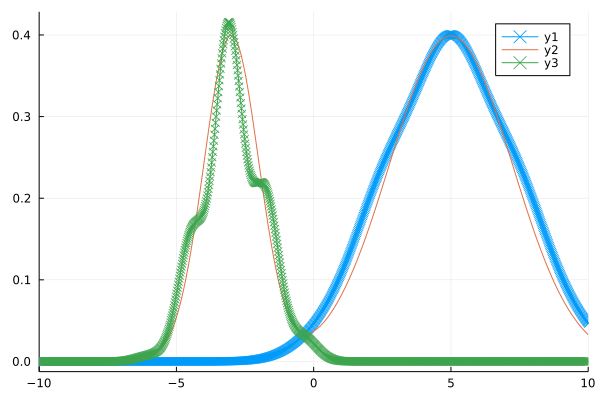

In [24]:
δ = 1.2
p = 0.25
gaussian(x, μ) = exp(-0.5 * ((x-μ)/δ)^2)/(sqrt(2π) * p)

#hole
δh = 0.5
ph = 0.25
gaussianh(x, μh) = exp(-0.5 * ((x-μh)/δh)^2)/(sqrt(2π) * ph)

aomega_reconst = zeros(Float64, length(omegas))
for ie in eachindex(e.values)
    aomega_reconst .+= gaussian.(omegas, e.values[ie]) * weight[ie]
end

#hole
aomega_reconsth = zeros(Float64, length(omegas))
for ieh in eachindex(eh.values)
    aomega_reconsth .+= gaussianh.(omegas, eh.values[ieh]) * weighth[ieh]
end


p = plot(xlim=(-wmax, wmax))
plot!(p, omegas, 0.5 * (aomega_reconst), xlim=(-wmax, wmax), marker=:x)
plot!(p, omegas, aomega.(omegas))
plot!(p, omegas, 0.5 * (aomega_reconsth), xlim=(-wmax, wmax), marker=:x)